# References
# ==========================================================

- https://twitter.com/dog_rates 
- https://en.wikipedia.org/wiki/WeRateDogs
- https://help.twitter.com/en/managing-your-account/how-to-download-your-twitter-archive
- https://docs.tweepy.org/en/latest/
- https://developer.twitter.com/en/docs/developer-portal/overview
- https://docs.google.com/presentation/d/1Peq5xknubzVYWhGftH39zPTnfke7qJ1q4-nFqCCOmvw/edit

# Notes
# ==========================================================

- Detect and document at least eight (8) quality issues and two (2) tidiness issues
- Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv
- At least three (3) insights and one (1) visualization must be produced.
- Create a 300-600 word written report called wrangle_report.pdf or wrangle_report.html that briefly describes your wrangling efforts. This is to be framed as an internal document.
- Create a 250-word-minimum written report called act_report.pdf or act_report.html that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.
- JSON = Java Script Object Notation

# Enhanced Twitter Archive

- The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. 
- One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." 
- Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).
- I extracted this data programmatically, but I didn't do a very good job. 
    - The ratings probably aren't all correct. 
    - Same goes for the dog names 
    - And probably dog stages  too. 
- You'll need to assess and clean these columns if you want to use them for analysis and visualization.

# Additional Data via the Twitter API

- Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. 
- Fortunately, this additional data can be gathered by anyone from Twitter's API. 
    - Well, "anyone" who has access to data for the 3000 most recent tweets, at least. 
    - But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. 
    - And guess what? You're going to query Twitter's API to gather this valuable data.

# Image Predictions File

- One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. 
- The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

The column description:
- tweet_id 
    - the last part of the tweet URL after "status/"
- p1 
    - the algorithm's #1 prediction for the image in the tweet
- p1_conf
    - how confident the algorithm is in its #1 prediction
- p1_dog 
    - whether or not the #1 prediction is a breed of dog
etc.

# Import Library
# ==========================================================

In [1]:
# Import all packages
import os
import pandas as pd
import numpy  as np
import requests
import json
import requests

In [2]:
# Import lirarbies for plotting 
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Changing the size of the plots:
from matplotlib import rcParams
# Specify the figure size in inches, for both X, and Y axes
rcParams['figure.figsize'] = 15,8

In [3]:
def download_file(url):
  """
  This function is used to download a file from the internet 
  Input: the URL link of the file
  Output: a version of the file in the current working directory
  Dependecny: reuests library
  """
  response = requests.get(url, allow_redirects=True)
  with open(url.split("/")[-1], mode = 'wb') as file:
      file.write(response.content)

In [4]:
# Regex for extracting a url link from a text
re_url      = r'(?P<url>https?://[^\s]+)'
# Regex for extracting a fraction from a text
re_fraction = r'(?:(?P<rating_numerator>[-+]?\d*\.\d+|\d+)\/(?P<rating_denominator>[-+]?\d*\.\d+|\d+))'

# Data Gathering 
# ==========================================================

In [5]:
# URLs for the files that should be downloaded
twitter_archive_enhanced_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv"
image_prediction_url         = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
tweet_json_url               = "https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt"

In [6]:
# Download the files in the current directory
download_file(twitter_archive_enhanced_url)
download_file(image_prediction_url)
download_file(tweet_json_url)

In [7]:
# Create a dataframe for each dataset
twitter_archive_enhanced_df = pd.read_csv(twitter_archive_enhanced_url.split("/")[-1])
image_predictions_pd        = pd.read_csv(image_prediction_url.split("/")[-1], sep = "\t")

In [8]:
# Create a dataframe for jason file
with open(tweet_json_url.split("/")[-1], encoding='utf-8') as f:
    data = "[" + f.read().replace("}\n", "},\n") + "]"
    data = data[:-3]  + "]"
    data = json.loads(data)
json_df = pd.DataFrame.from_dict(data)
json_df.to_csv('json.csv', index=False)

# Data Assessing
# ==========================================================

In [9]:
twitter_archive_enhanced_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twitter_archive_enhanced_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
twitter_archive_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter_archive_enhanced_df.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [13]:
twitter_archive_enhanced_df[twitter_archive_enhanced_df.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [14]:
twitter_archive_enhanced_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
twitter_archive_enhanced_df[twitter_archive_enhanced_df.rating_numerator<10].rating_numerator.value_counts().sum()

440

In [16]:
image_predictions_pd.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
image_predictions_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
image_predictions_pd.isna().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [19]:
image_predictions_pd[image_predictions_pd.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


## Quality Issues
- The datatype of “timestamp” is not correct.
- The datatype of of "tweet_id" is "int64"
- The "timestamp" records have the same time zone.
- There is records related to retweet and reply and we should not take them into our analysis.
- The column "source" contains html code.
- The column “text” contains short url links.
- The column “text” contains “&amp;”.
- The following columns contains 'None' value (doggo, floofer, pupper, puppo, name)
- The column name contains incorrect names that start will lower case.
- Some column names are not descriptive.
- The “rating_denominator” contains value other than 10.


## Tidiness Issues
- The columns (doggo, floofer, pupper, puppo) have the same information about the “dog_stage” and should be in one column.
- The three tables are parts of the same tweet and should be in one master table. 

# Data Cleaning
# ==========================================================

In [20]:
# Make a copy of the original dataset
twitter_archive_master  = twitter_archive_enhanced_df.copy()
image_predictions_clean = image_predictions_pd.copy()

## Point: Type of the column 'timestamp' is not datetime

### Define
- Change the data type of the 'timestamp' column to date instead of object

### Code

In [21]:
# Remove the time zone from the 'timestamp'
twitter_archive_master.timestamp = twitter_archive_master.timestamp.str[:-6]

In [22]:
# Convert the data type to 'datetime' with the appropriate format
twitter_archive_master.timestamp = pd.to_datetime(twitter_archive_master.timestamp, format = "%Y-%m-%d %H:%M:%S")

### Test

In [23]:
# Check the difference of the datatype between the original and copyied data set
print("Before: ", twitter_archive_enhanced_df.timestamp.dtype)
print("After:  ", twitter_archive_master.timestamp.dtype)

Before:  object
After:   datetime64[ns]


## Point: Information about the retweet and reply records

### Define
- As per the "Key Points" of the project: "You only want original ratings (no retweets) that have images."
- So we will remove the "retweeted" and "reply" records

### Code

In [24]:
# Remove the in_reply tweets
twitter_archive_master = twitter_archive_master[twitter_archive_master.in_reply_to_status_id.isna()].copy()
twitter_archive_master.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace = True)

In [25]:
# Remove the retweeted tweets
twitter_archive_master = twitter_archive_master[twitter_archive_master.retweeted_status_id.isna()].copy()
twitter_archive_master.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

### Test

In [26]:
# Check that the columns are dropped and rows are removed
print("Before: ", twitter_archive_enhanced_df.shape)
print("After:  ", twitter_archive_master.shape)

Before:  (2356, 17)
After:   (2097, 12)


## Point: The column source contains html code 

### Define
- Extract the source from the html in the "source" column

### Code

In [27]:
twitter_archive_master.loc[:,"source"] = twitter_archive_master.source.str.extract(r">(.*)<")[0]

### Test

In [28]:
# Before
twitter_archive_enhanced_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [29]:
# After
twitter_archive_master.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

## Point: 'text' column contains short_url

### Define
- Extract the 'short_url' in a new column

### Code

In [30]:
# https://stackoverflow.com/questions/839994/extracting-a-url-in-python
# https://stackoverflow.com/questions/42379389/finding-all-regex-matches-from-a-pandas-dataframe-column
twitter_archive_master['short_url'] = twitter_archive_master.text.str.extractall(re_url).unstack().apply(lambda x:', '.join(x.dropna()), axis=1)
twitter_archive_master.text = twitter_archive_master.text.str.replace(re_url, "").str.strip()

### Test

In [31]:
# Check that the 'short_url' column is created with its content
twitter_archive_master['short_url']

0       https://t.co/MgUWQ76dJU
1       https://t.co/0Xxu71qeIV
2       https://t.co/wUnZnhtVJB
3       https://t.co/tD36da7qLQ
4       https://t.co/AtUZn91f7f
                 ...           
2351    https://t.co/4B7cOc1EDq
2352    https://t.co/DWnyCjf2mx
2353    https://t.co/y671yMhoiR
2354    https://t.co/r7mOb2m0UI
2355    https://t.co/BLDqew2Ijj
Name: short_url, Length: 2097, dtype: object

In [32]:
# Check that the url is removed from the text
twitter_archive_master.text[3]

'This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us'

## Point: 'text' column contains "& amp;" instead of "&"

### Define
- Replace "& amp;" with "&"

### Code

In [33]:
twitter_archive_master.text = twitter_archive_master.text.replace('&amp;','&', regex=True)

### Test

In [34]:
print("Before: ", (twitter_archive_enhanced_df.text.str.contains('&amp;')).sum())
print("After:  ", (twitter_archive_master.text.str.contains('&amp;')).sum())

Before:  54
After:   0


## Point: Dog type are in 4 columns

### Define
- Combine the 4 columns of dog type into one

### Code

In [35]:
# The columns that contains dog types
dog_type_columns = ['doggo','floofer', 'pupper', 'puppo']
# Remove "None" from the columns
twitter_archive_master.loc[:, dog_type_columns] = twitter_archive_master[dog_type_columns].replace(to_replace='None', value="")

In [36]:
# Combine the information into one column 'dog_stage'
twitter_archive_master['dog_stage'] = twitter_archive_master[dog_type_columns].sum(axis=1).replace(to_replace='', value=np.nan)
# Remove the old columns as they have duplicate information now
twitter_archive_master.drop(dog_type_columns, axis = 1, inplace = True)

In [37]:
# Fix records that have multiple stage 
twitter_archive_master.loc[twitter_archive_master.dog_stage == 'doggopupper',  'dog_stage'] = 'doggo, pupper'
twitter_archive_master.loc[twitter_archive_master.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'
twitter_archive_master.loc[twitter_archive_master.dog_stage == 'doggopuppo',   'dog_stage'] = 'doggo, puppo'

### Test

In [38]:
twitter_archive_master.dog_stage.value_counts()

pupper            221
doggo              72
puppo              23
doggo, pupper       9
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

## Point: The "name" column contain "None" and name wit lower case are incorrect

### Define
- Replace "None" with np.nan

### Code

In [39]:
# Extract the name from the 'text' as per the pattern 'named\s*([A-Z]\w+)'
lower_case_names = twitter_archive_master[twitter_archive_master.name.str.islower() | (twitter_archive_master.name == "None")].copy()
Dummy            = lower_case_names.text.str.extract(r'named\s*([A-Z]\w+)').dropna()
twitter_archive_master.loc[Dummy.index,"name"] = Dummy[0]

In [40]:
# Extract the name from the 'text' as per the pattern 'This is\s*([A-Z]\w+)'
lower_case_names = twitter_archive_master[twitter_archive_master.name.str.islower() | (twitter_archive_master.name == "None")].copy()
Dummy            = lower_case_names.text.str.extract(r'[t,T]his is\s*([A-Z]\w+)').dropna()
twitter_archive_master.loc[Dummy.index,"name"] = Dummy[0]

In [41]:
# Remove the lower case names from the columns
lower_case_names = twitter_archive_master[twitter_archive_master.name.str.islower()].copy()
twitter_archive_master.loc[lower_case_names.index,"name"] = np.nan
twitter_archive_master.name.replace(to_replace='None', value=np.nan, inplace = True)

### Test

In [42]:
(twitter_archive_master.name == 'None').sum()
print("Before: ", (twitter_archive_enhanced_df.name == 'None').sum())
print("Before: ", (twitter_archive_master.name == 'None').sum())

Before:  745
Before:  0


In [43]:
twitter_archive_master.name.value_counts()

Charlie     11
Lucy        11
Oliver      10
Cooper      10
Penny        9
            ..
Terrance     1
Barclay      1
Callie       1
Dwight       1
Flash        1
Name: name, Length: 949, dtype: int64

In [44]:
twitter_archive_master.name.isna().sum()

682

## Point: Adding retweet count and favorite count

### Define
- Merge the retweet count and favorite count from Json file

### Code

In [45]:
# The columns that will be merged
columns_to_merge = ['id', 'retweet_count', 'favorite_count']
# Merging 
twitter_archive_master = pd.merge(twitter_archive_master, json_df[columns_to_merge], left_on = "tweet_id", right_on = "id", how='left').drop('id', axis = 1)

### Test

In [46]:
twitter_archive_master.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,short_url,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://t.co/MgUWQ76dJU,NaN,8853,39467


In [47]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1415 non-null object
short_url             2094 non-null object
dog_stage             336 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 213.0+ KB


## Point: the column names of the prediction are not descriptive

### Define
- Rename the columns in the prediction table

### Code

In [48]:
image_predictions_clean.rename(columns={"img_num": "number_of_images",
                                        "p1": "first_prediction", "p2": "second_prediction", "p3": "third_prediction",
                                        "p1_conf": "first_confidence", "p2_conf": "second_confidence", "p3_conf": "third_confidence",
                                        "p1_dog": "first_is_dog", "p2_dog": "second_is_dog", "p3_dog": "third_is_dog"},
                                inplace = True)

### Test

In [49]:
image_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'number_of_images', 'first_prediction',
       'first_confidence', 'first_is_dog', 'second_prediction',
       'second_confidence', 'second_is_dog', 'third_prediction',
       'third_confidence', 'third_is_dog'],
      dtype='object')

## Point: Adding image prediction

### Define
- Combine the image prediction with the twitter archive

### Code

In [50]:
twitter_archive_master = pd.merge(twitter_archive_master, image_predictions_clean, left_on = "tweet_id", right_on = "tweet_id", how='inner')

### Test

In [51]:
twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'short_url',
       'dog_stage', 'retweet_count', 'favorite_count', 'jpg_url',
       'number_of_images', 'first_prediction', 'first_confidence',
       'first_is_dog', 'second_prediction', 'second_confidence',
       'second_is_dog', 'third_prediction', 'third_confidence',
       'third_is_dog'],
      dtype='object')

## Point: the "rating_denominator" contains values not equal to 10

### Define
- Fix the row that have the correct information the 'text' column and drop the others

### Code

In [52]:
# Correct the rating as per the information in 'text' column
twitter_archive_master.loc[1068, ["rating_numerator", "rating_denominator"]] = [14, 10]
twitter_archive_master.loc[1165, ["rating_numerator", "rating_denominator"]] = [13, 10]
twitter_archive_master.loc[1202, ["rating_numerator", "rating_denominator"]] = [1, 10]
twitter_archive_master.loc[1662, ["rating_numerator", "rating_denominator"]] = [10, 10]
twitter_archive_master.loc[2335, ["rating_numerator", "rating_denominator"]] = [9, 10]

twitter_archive_master.loc[794,  ["rating_numerator", "rating_denominator"]] = [14, 10]
twitter_archive_master.loc[884,  ["rating_numerator", "rating_denominator"]] = [13, 10]
twitter_archive_master.loc[918,  ["rating_numerator", "rating_denominator"]] = [11, 10]
twitter_archive_master.loc[1313, ["rating_numerator", "rating_denominator"]] = [10, 10]
twitter_archive_master.loc[1950, ["rating_numerator", "rating_denominator"]] = [9, 10]

In [53]:
# Drop the rows that have denominator not equal to 10
twitter_archive_master = twitter_archive_master[twitter_archive_master.rating_denominator == 10]
twitter_archive_master.drop("rating_denominator", axis = 1, inplace = True)

### Test

In [54]:
twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'name', 'short_url', 'dog_stage', 'retweet_count',
       'favorite_count', 'jpg_url', 'number_of_images', 'first_prediction',
       'first_confidence', 'first_is_dog', 'second_prediction',
       'second_confidence', 'second_is_dog', 'third_prediction',
       'third_confidence', 'third_is_dog'],
      dtype='object')

## Point: The type of "tweet_id" is float

### Define
- Convert the type of 'tweet_id' to object

### Code

In [55]:
twitter_archive_master.tweet_id = twitter_archive_master.tweet_id.astype('object')

### Test

In [56]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960 entries, 0 to 2335
Data columns (total 22 columns):
tweet_id             1959 non-null object
timestamp            1959 non-null datetime64[ns]
source               1959 non-null object
text                 1959 non-null object
expanded_urls        1959 non-null object
rating_numerator     1960 non-null float64
name                 1373 non-null object
short_url            1959 non-null object
dog_stage            303 non-null object
retweet_count        1959 non-null float64
favorite_count       1959 non-null float64
jpg_url              1959 non-null object
number_of_images     1959 non-null float64
first_prediction     1959 non-null object
first_confidence     1959 non-null float64
first_is_dog         1959 non-null object
second_prediction    1959 non-null object
second_confidence    1959 non-null float64
second_is_dog        1959 non-null object
third_prediction     1959 non-null object
third_confidence     1959 non-null float

# Store the Data

In [57]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

# Analyzation and Visualization

## The twitter count with years

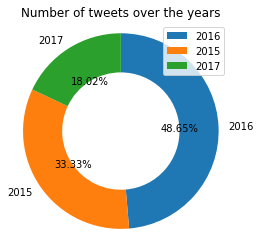

In [58]:
pie_input = twitter_archive_master.timestamp.dt.year.dropna().astype('int').value_counts()
plt.pie(pie_input,
        labels = pie_input.index,
        startangle = 90, 
        counterclock = False, 
        autopct='%1.2f%%', 
        wedgeprops = {'width' : 0.4}); 
plt.axis('square');   
plt.legend(); 
plt.title("Number of tweets over the years");


> <font color='red'> 
Insights:
* The number of tweets was at the peek in the year 2016 and then decreases
</font>

## The Twitter Sources

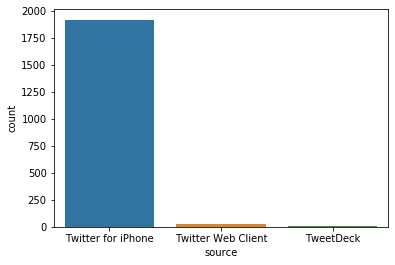

In [59]:
sb.countplot(data = twitter_archive_master, x = "source");

> <font color='red'> 
Insights:
* The common source of tweets in from the iphone
* The other sources can e neglected  
</font>

## Relation between the retweet counts and the favorite counts

Text(0.5, 1.0, 'Relation between the retweent counts with the favorite counts')

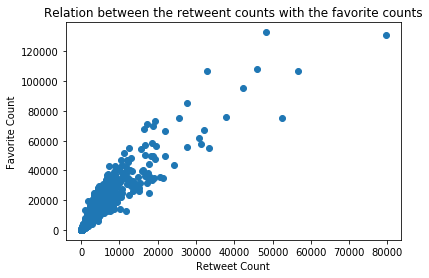

In [60]:
plt.scatter(data = twitter_archive_master, 
            x = "retweet_count", 
            y = "favorite_count");
plt.xlabel("Retweet Count");
plt.ylabel("Favorite Count");
plt.title("Relation between the retweent counts with the favorite counts")

> <font color='red'> 
Insights:
* The relation is linear between the retweent count and the favorite count
</font>

## Relation between the number of tweet with time

In [61]:
# https://stackoverflow.com/questions/26646191/pandas-groupby-month-and-year
per = twitter_archive_master.timestamp.dt.to_period("D")  # new way to get the same
df  = twitter_archive_master.groupby(per)['tweet_id'].count().reset_index()

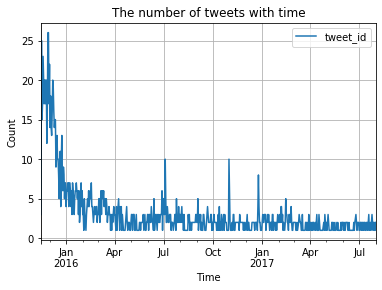

In [62]:
df.plot(x="timestamp", y="tweet_id");
plt.title("The number of tweets with time");
plt.xlabel("Time")
plt.ylabel("Count")
plt.grid()

> <font color='red'> 
Insights:
* The number of tweets decrease with time
</font>

# <h1><center>Thanks You</center></h1>